<a href="https://colab.research.google.com/github/mamekin05108/signatecup2024summer/blob/main/CatBoost%2Bcali(LB0_8382866).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

# warningsを非表示にする
warnings.filterwarnings("ignore")

In [41]:
df_train = pd.read_csv("/content/drive/MyDrive/Signate/2024summer/fdata/df_train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Signate/2024summer/fdata/df_test.csv")
ss = pd.read_csv("/content/drive/MyDrive/Signate/2024summer/data/sample_submit.csv", header=None)

In [42]:
df_train.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,ProdTaken,MaritalStatus,OwnCar,NumberOfChildren,Agebin,Incomebin
0,0,50.0,Self Enquiry,2,15.0,Large Business,MALE,1.0,4.0,BASIC,...,1,4,Executive,253905.0,1.0,未婚,なし,0.0,41-50,<300000
1,1,56.0,Company Invited,1,14.0,Salaried,MALE,1.0,4.0,STANDARD,...,1,4,Senior Manager,404475.0,0.0,離婚,あり,0.0,51-65,<450000
2,2,NaN,Self Enquiry,1,10.0,Large Business,FEMALE,1.0,3.0,BASIC,...,0,4,Executive,278145.0,1.0,結婚,なし,0.0,NaN,<300000
3,3,37.0,Self Enquiry,2,18.0,Small Business,FEMALE,1.0,3.0,STANDARD,...,0,5,Senior Manager,326805.0,0.0,離婚,あり,0.0,31-40,<350000
4,4,48.0,Company Invited,3,17.0,Small Business,FEMALE,1.0,3.0,BASIC,...,0,4,Executive,258435.0,1.0,独身,あり,0.0,41-50,<300000


In [43]:
rows = []
for col in df_train.columns:
    rows.append([col, df_train[col].dtype, df_train[col].isnull().sum(), len(df_train[col].unique())])
pd.DataFrame(rows, columns=["列名", "列の型", "NaNである行の数", "値の種類"])

,列名,列の型,NaNである行の数,値の種類
0,id,int64,0,3489
1,Age,float64,100,45
2,TypeofContact,object,6,3
3,CityTier,int64,0,3
4,DurationOfPitch,float64,121,34
5,Occupation,object,0,3
6,Gender,object,0,2
7,NumberOfPersonVisiting,float64,0,4
8,NumberOfFollowups,float64,33,7
9,ProductPitched,object,0,5


In [44]:
# Config cell
target = "ProdTaken"
path_in_folder = "./"

cols_category = [
    "Gender",
    "ProductPitched",
    "Designation",
    "MaritalStatus",
    "OwnCar",
    "Occupation",
    "TypeofContact",
    "Agebin",
    "Incomebin"
]

In [45]:
def preprocess(df, replace_dict=None, ce_dict=None):
    # カテゴリカル変数の設定
    df[cols_category] = df[cols_category].fillna(-1)
    if replace_dict is None:
        # countencode, labelencode
        # ce_dict: 列名を入れるとそのカテゴリのデータがどのくらいあるかを返してくれます
        # replace_dict: 列名を入れるとlabelencodeのための数字を返してくれます
        ce_dict = {}
        replace_dict = {}
        for col in cols_category:
            replace_dict[col] = {}
            vc = df[col].value_counts()
            ce_dict[col] = vc
            replace_dict_in_dict = {}
            for i, k in enumerate(vc.keys()):
                replace_dict_in_dict[k] = i
            replace_dict[col] = replace_dict_in_dict
            df[f"{col}_CountEncode"] = df[col].replace(vc).astype(int)
            df[col] = df[col].replace(replace_dict_in_dict).astype(int)
        return df, replace_dict, ce_dict

    # test
    else:
        for col in cols_category:
            # カウントエンコード
            test_vals_uniq = df[col].unique()
            ce_dict_in_dict = ce_dict[col]
            for test_val in test_vals_uniq:
                if test_val not in ce_dict_in_dict.keys():
                    ce_dict_in_dict[test_val] = -1
            df[f"{col}_CountEncode"] = df[col].replace(ce_dict_in_dict).astype(int)

            # LabelEncode
            test_vals_uniq = df[col].unique()
            replace_dict_in_dict = replace_dict[col]
            for test_val in test_vals_uniq:
                if test_val not in replace_dict_in_dict.keys():
                    replace_dict_in_dict[test_val] = -1
            df[col] = df[col].replace(replace_dict_in_dict).astype(int)
        return df

In [46]:
df_train, replace_dict, ce_dict = preprocess(df_train)
df_test = preprocess(df_test, replace_dict=replace_dict, ce_dict=ce_dict)

In [47]:
df_train.head()


,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,Incomebin,Gender_CountEncode,ProductPitched_CountEncode,Designation_CountEncode,MaritalStatus_CountEncode,OwnCar_CountEncode,Occupation_CountEncode,TypeofContact_CountEncode,Agebin_CountEncode,Incomebin_CountEncode
0,0,50.0,0,2,15.0,2,0,1.0,4.0,0,...,1,2064,1157,1150,581,1785,361,2194,843,832
1,1,56.0,1,1,14.0,1,0,1.0,4.0,2,...,3,2064,841,854,878,1704,1401,1289,527,318
2,2,NaN,0,1,10.0,2,1,1.0,3.0,0,...,1,1425,1157,1150,1384,1785,361,2194,100,832
3,3,37.0,0,2,18.0,0,1,1.0,3.0,2,...,0,1425,841,854,878,1704,1727,2194,1126,1003
4,4,48.0,1,3,17.0,0,1,1.0,3.0,0,...,1,1425,1157,1150,646,1704,1727,1289,843,832


In [48]:
rows = []
for col in df_train.columns:
    rows.append([col, df_train[col].dtype, df_train[col].isnull().sum(), len(df_train[col].unique())])
pd.DataFrame(rows, columns=["列名", "列の型", "NaNである行の数", "値の種類"])

,列名,列の型,NaNである行の数,値の種類
0,id,int64,0,3489
1,Age,float64,100,45
2,TypeofContact,int64,0,3
3,CityTier,int64,0,3
4,DurationOfPitch,float64,121,34
5,Occupation,int64,0,3
6,Gender,int64,0,2
7,NumberOfPersonVisiting,float64,0,4
8,NumberOfFollowups,float64,33,7
9,ProductPitched,int64,0,5


In [49]:
df_train.drop(["id"], axis=1, inplace=True)
df_test.drop(["id"], axis=1, inplace=True)

In [50]:
train_y = df_train[target]
train_x = df_train.drop(target, axis=1)

In [ ]:
#df_train.to_csv("/content/drive/MyDrive/Signate/2024summer/dft_train.csv", index=False)
#df_test.to_csv("/content/drive/MyDrive/Signate/2024summer/dft_test.csv", index=False)

In [51]:
params_lgb = {
    "n_estimators": 3000,
    "learning_rate": 0.01,
    "colsample_bytree": 0.8,
    "subsample_freq": 1,
    "subsample": 0.8,
    "random_seed": 0,
}

In [52]:
params_cat = {
    "iterations": 3000,  # n_estimatorsに相当
    "learning_rate": 0.01,
    "colsample_bylevel": 0.8,  # colsample_bytreeに相当
    "random_seed": 0,
    "verbose": 100,  # 学習の進捗を100回毎に表示
    "use_best_model": True,  # 早期停止のための設定
}

In [53]:
# f1スコアが最も高くなる点を見つける
from sklearn import metrics
def decide_cutoff(val_y, preds_y_proba):
    mean_f1_list = []
    fpr, tpr, thresholds = metrics.roc_curve(val_y, preds_y_proba)
    for threshold in thresholds:
        preds_y = [1 if prob > threshold else 0 for prob in preds_y_proba]
        #preds_y=preds_y_proba
        mean_f1_list.append(f1_score(val_y, preds_y, average='macro'))
    return np.max(mean_f1_list), thresholds[np.argmax(mean_f1_list)]

In [30]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.0 MB/s eta 0:00:00


In [56]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool
from sklearn.isotonic import IsotonicRegression

In [58]:
list_metrics_auc = []
list_metrics_f1 = []
list_cutoff = []
list_models = []
fraction_of_positives_list = []
mean_predicted_value_list = []

calibration_models = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for fold, (trn_idx, val_idx) in enumerate(cv.split(train_x, train_y), start=1):
    trn_x = train_x.iloc[trn_idx, :]
    trn_y = train_y[trn_idx]
    val_x = train_x.iloc[val_idx, :]
    val_y = train_y[val_idx]
    train_pool = Pool(data=trn_x, label=trn_y, cat_features=cols_category)
    val_pool = Pool(data=val_x, label=val_y, cat_features=cols_category)

    model_cat = CatBoostClassifier(**params_cat, early_stopping_rounds=100)
    model_cat.fit(train_pool, eval_set=val_pool)

    list_models.append(model_cat)

    # Get the predicted probabilities on validation data
    val_pred_proba = model_cat.predict_proba(val_x)[:, 1]

    # Calibrate the probabilities manually using Isotonic Regression
    iso_reg = IsotonicRegression(out_of_bounds='clip')
    iso_reg.fit(val_pred_proba, val_y)
    calibrated_proba = iso_reg.transform(val_pred_proba)
    calibration_models.append(iso_reg)

    auc = roc_auc_score(val_y, calibrated_proba)
    f1, threshold = decide_cutoff(val_y, calibrated_proba)
    list_metrics_auc.append(auc)
    list_metrics_f1.append(f1)
    list_cutoff.append(threshold)
    print(f"Fold: {fold}, AUC: {auc}, f1 score: {f1} Threshold: {threshold}")

    # キャリブレーション曲線を計算
    fraction_of_positives, mean_predicted_value = calibration_curve(val_y, calibrated_proba, n_bins=10)
    fraction_of_positives_list.append(fraction_of_positives)
    mean_predicted_value_list.append(mean_predicted_value)

0:	learn: 0.6843478	test: 0.6846110	best: 0.6846110 (0)	total: 7.13ms	remaining: 21.4s
100:	learn: 0.3498409	test: 0.3532370	best: 0.3532370 (100)	total: 813ms	remaining: 23.3s
200:	learn: 0.2992319	test: 0.3080462	best: 0.3080462 (200)	total: 2.27s	remaining: 31.7s
300:	learn: 0.2790613	test: 0.2959356	best: 0.2959356 (300)	total: 3.81s	remaining: 34.2s
400:	learn: 0.2663716	test: 0.2921129	best: 0.2921129 (400)	total: 5.21s	remaining: 33.7s
500:	learn: 0.2568140	test: 0.2905511	best: 0.2903929 (486)	total: 6.03s	remaining: 30.1s
600:	learn: 0.2485444	test: 0.2897432	best: 0.2897432 (600)	total: 6.87s	remaining: 27.4s
700:	learn: 0.2415264	test: 0.2894212	best: 0.2894212 (700)	total: 7.68s	remaining: 25.2s
800:	learn: 0.2339052	test: 0.2896998	best: 0.2893443 (703)	total: 8.54s	remaining: 23.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2893443322
bestIteration = 703

Shrink model to first 704 iterations.
Fold: 1, AUC: 0.8763210702341138, f1 score: 0.76250220

In [33]:
# AUC
print(np.mean(list_metrics_auc), np.mean(list_metrics_f1), np.median(list_cutoff))

0.838430501913626 0.7237247743604521 0.2595655837694162


0.838430501913626 0.7237247743604521 0.2595655837694162



In [59]:
# AUC
print(np.mean(list_metrics_auc), np.mean(list_metrics_f1), np.median(list_cutoff))

0.8527140753039351 0.7268991242790431 0.25


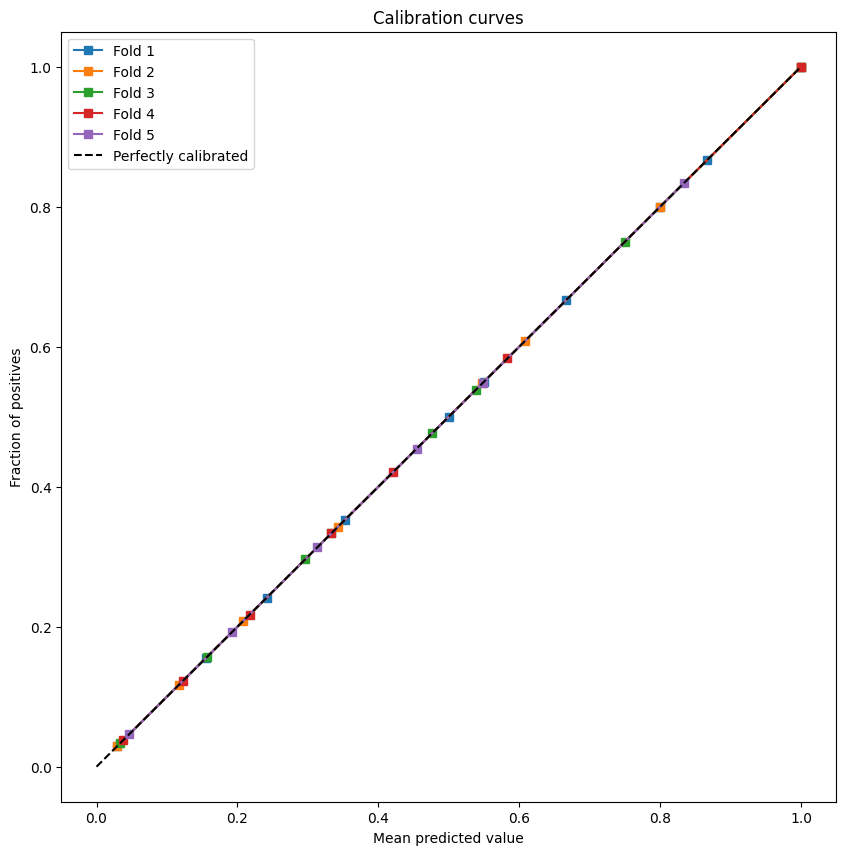

In [60]:
# キャリブレーション曲線の描画
plt.figure(figsize=(10, 10))
for i in range(cv.n_splits):
    plt.plot(mean_predicted_value_list[i], fraction_of_positives_list[i], "s-", label=f"Fold {i+1}")

plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves")
plt.legend()
plt.show()

In [61]:
threshold = np.median(list_cutoff)
preds_y_proba = np.zeros(len(df_test))
for model, calib_model in zip(list_models, calibration_models):
    # モデルに必要な特徴量を取得
    feature_names = model.feature_names_
    test_pred_proba = model.predict_proba(df_test[feature_names])[:, 1]
    calibrated_test_proba = calib_model.transform(test_pred_proba)
    preds_y_proba += calibrated_test_proba / len(list_models)
    print(f"Model: {model}, Proba: {preds_y_proba}")  # 予測確率を表示
preds_y = preds_y_proba

Model: <catboost.core.CatBoostClassifier object at 0x7dab38844d00>, Proba: [0.00967742 0.03119266 0.0625     ... 0.16734647 0.07777778 0.        ]
Model: <catboost.core.CatBoostClassifier object at 0x7daad652c850>, Proba: [0.03310084 0.07205288 0.13206522 ... 0.2890856  0.147343   0.        ]
Model: <catboost.core.CatBoostClassifier object at 0x7daad4d5e470>, Proba: [0.04949429 0.10335722 0.19132448 ... 0.4890856  0.21400966 0.        ]
Model: <catboost.core.CatBoostClassifier object at 0x7daaf5b8ba00>, Proba: [0.06879253 0.12745361 0.27367742 ... 0.66981067 0.28067633 0.        ]
Model: <catboost.core.CatBoostClassifier object at 0x7daad4c394b0>, Proba: [0.08739718 0.16580977 0.33428348 ... 0.83647734 0.34128239 0.        ]


In [38]:
count = 0

In [62]:
from datetime import datetime
import pytz
# カウント変数をインクリメント
count += 1
# 日本時間を取得
japan_tz = pytz.timezone('Asia/Tokyo')
now = datetime.now(japan_tz)
timestamp = now.strftime("%Y%m%d_%H%M%S")

file_name = f"/content/drive/MyDrive/Signate/2024summer/catboost_cali_{timestamp}_{count:03d}.csv"
ss[1] = preds_y
ss.to_csv(file_name, header=False, index=False)